In [1]:
import pickle
import shutil
import glob
import abc
import gc
import os

from sklearn.random_projection import SparseRandomProjection
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import pairwise_distances
from torchvision.models import wide_resnet50_2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from scipy.ndimage import gaussian_filter
from easydict import EasyDict as edict
from imutils.paths import list_images
from torch.nn import functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn as nn
from PIL import Image
import numpy as np
import faiss
import torch
import cv2

/opt/conda/envs/anomaly/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gc.collect()

22

In [3]:
ROOT_PATH = '/'.join(os.getcwd().split('/')[:-4])
DATA_PATH = f'{ROOT_PATH}/dataset/MVTecDataset'

In [4]:
class SamplingMethod(object):
    
    __metaclass__ = abc.ABCMeta
    
    @abc.abstractmethod
    def __init__(self, x, y, seed, **kwargs):
        
        self.x    = x
        self.y    = y
        self.seed = seed
        
        
    def flatten_x(self):
        
        shape  = self.x.shape
        flat_x = self.x
        
        if len(shape) > 2: flat_x = np.reshape(self.x, (shape[0], np.product(shape[1:])))
        
        return flat_x
    
    
    @abc.abstractmethod
    def _select_batch(self): return


    def select_batch(self, **kwargs): return self._select_batch(**kwargs) 


    def to_dict(self): return None

In [5]:
class KCenterGreedy(SamplingMethod):
    
    def __init__(self, x, y, seed, metric = 'euclidean'):
        
        self.x                = x
        self.y                = y
        self.n_obs            = self.x.shape[0]
        self.metric           = metric
        self.flat_x           = self.flatten_x()
        self.features         = self.flat_x
        self.min_dist         = None
        self.already_selected = []
        
        
    def update_distances(self, cluster_centers, only_new = True, reset_dist = False):
        
        if reset_dist: self.min_dist = None
        if   only_new: cluster_centers = [d for d in cluster_centers
                                          if d not in self.already_selected]
        
        if cluster_centers:
            
            x    = self.features[cluster_centers]
            dist = pairwise_distances(self.features, x, metric = self.metric)
            
            self.min_dist = np.min(dist, axis = 1).reshape(-1, 1) if self.min_dist is None \
                            else np.minimum(self.min_dist, dist)     
            
            
    def select_batch_(self, model, already_selected, N, **kwargs):
        
        try:
            print('\nGetting transformed features...')
            self.features = model.transform(self.x)
            print('Compute distances...')
            
            self.update_distances(already_selected, only_new = False, reset_dist = True)
            
        except:
            
            print('Using flat_X as features')
            self.update_distances(already_selected, only_new = True, reset_dist = False)
            
            
        new_batch = []
        
        for _ in range(N):
            
            idx = np.random.choice(np.arange(self.n_obs)) if self.already_selected is None \
                  else np.argmax(self.min_dist)
            
            assert idx not in already_selected
            self.update_distances([idx], only_new = True, reset_dist = False)
            new_batch.append(idx)
        
        print(f'Maximum distance from cluster centers is {max(self.min_dist)[0]:.2f}')
        self.already_selected = already_selected
        
        
        return new_batch

In [6]:
makedirs    = lambda path: os.makedirs(path, exist_ok = True)
cvt2heatmap = lambda gray: cv2.applyColorMap(np.uint8(gray), cv2.COLORMAP_JET) 

def distance_matrix(x, y = None, p = 2):
    
    y    = x if type(y) == type(None) else y
    
    n    = x.size(0)
    m    = y.size(0)
    d    = x.size(1)
    
    x    = x.unsqueeze(1).expand(n, m, d)
    y    = y.unsqueeze(0).expand(n, m, d)
    
    dist = torch.pow(x - y, p).sum(2)
    
    return dist


def copy_files(src, dst, ignores = []):
    
    file_names = os.listdir(src)
    for file_name in file_names:
        
        ignore_check = [True for idx in ignores if idx in file_name]
        if ignore_check: continue
        
        full_file_name = os.path.join(src, file_name)
        if os.path.isfile(full_file_name): 
            shutil.copy(full_file_name, os.path.join(dst, file_name))
            
        if os.path.isdir(full_File_name):
            os.makedirs(os.path.join(dst, file_name), exist_ok = True)
            copy_files(full_file_name, os.path.join(dst, file_name), ignores)
            

            
def prep_dirs(root):
    
    embeddings_path = os.path.join('./', args.model_path)  
    sample_path     = os.path.join('./', 'sample')
    source_path     = os.path.join(root, 'src')
    
    makedirs(embeddings_path)
    makedirs(sample_path)
    makedirs(source_path)
    
    return embeddings_path, sample_path, source_path


def heatmap_on_image(heatmap, image):
    
    shape = image.shape
    if heatmap.shape != image.shape: heatmap = cv2.resize(heatmap, (shape[0], shape[1]))
    
    out   = np.float32(heatmap) / 255 + np.float32(image) / 255
    out   = out / np.max(out)
    
    return np.uint8(255 * out)


def mix_max_norm(image):
    
    im_min, im_max = image.min(), image.max()
    return im_min, im_max, (image - im_min) / (im_max - im_min)


def fixed_min_max_norm(image, min_value, max_value):
    
    im_min, im_max = image.min(), image.max()
    return im_min, im_max, (image - min_value) / (max_value - min_value)
    
    

def cal_confusion_matrix(gt, pred_no_thr, thr, image_path_list):
    
    pred_thr, false_n, false_p = [], [], []
    
    for idx, pred in enumerate(pred_no_thr):
        
        if pred > thr:
            
            pred_thr.append(1)
            if gt[idx] == 0: false_p.append(image_path.list[idx])
            
        else:
            pred_thr.append(0)
            if gt[idx] == 1: false_n. append(image_path_list[idx])
            
            
    conf_mat = confusion_matrix(gt, pred_thr)
    
    print(conf_mat)
    print(f'# of false positive : {false_p}')
    print(f'# of false negative : {false_n}')

In [7]:
class NN:
    
    def __init__(self, x = None, y = None, p = 2):
        
        self.p = p
        self.train(x, y)
        
    
    def train(self, x, y):
        
        self.train_pts = x
        self.train_lb  = y
        
    
    def __call__(self, x): 
        
        return self.predict(x)

    
    def predict(self, x):
        
        condition = [type(self.train_pts) == type(None),
                     type(self.train_lb)  == type(None)]
        
        if any(condition):
            
            name == self.__class__.name
            raise RuntimeError(f'{name} wasn\'t trained. \nNeed to execute {name}.train() first')
            
        dist   = distance_matrix(x, self.train_pts, self.p) ** (1 / self.p)
        labels = torch.argmin(dist, dim = 1)
        
        return self.train_label[labels]
    

class KNN(NN):
    
    def __init__(self, x = None, y = None, k = 3, p = 2):
        
        super().__init__(x, y, p)
        self.k = k
        
        
    def train(self, x, y):
        
        super().train(x, y)
        if type(y) != type(None):
            self.unique_labels = self.train_label.unique()
            
    
    def predict(self, x):
        
        dist = distance_matrix(x, self.train_pts, self.p) ** (1 / self.p)
        knn  = dist.topk(self.k, largest = False)
        
        return knn

In [8]:
def embedding_concat(x, y):
    
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    
    ratio = int(H1 / H2)
    x     = F.unfold(x, kernel_size = ratio, dilation = 1, stride = ratio)
    x     = x.view(B, C1, -1, H2, W2)
    z     = torch.zeros(B, C1 + C2, x.size(2), H2, W2)
    
    for idx in range(x.size(2)): 
        z[:, :, idx, :, :] = torch.cat((x[:, :, idx, :, :], y), 1)
        
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size = ratio, output_size = (H1, W1), stride = ratio)
    
    return z


def reshape_embedding(embedding):
    
    embedding_list = []
    for i in range(embedding.shape[0]):
        
        for j in range(embedding.shape[2]):
            
            for k in range(embedding.shape[3]):
                
                embedding_list.append(embedding[i, :, j, k])
                
    return embedding_list


def get_args():
    
    config                           = {}
    config['coreset_sampling_ratio'] = 0.001
    config['save_anomaly_map']       = True
    config['dataset_path']           = DATA_PATH
    config['dataset_name']           = 'toothbrush'
    config['output_path']            = 'output'
    config['n_neighbors']            = 9
    config['batch_size']             = 16
    config['input_size']             = 224
    config['model_path']             = 'model'
    config['load_size']              = 256
    config['epochs']                 = 10
    config['phase']                  = 'train'
    
    return edict(config)

In [9]:
class MVTecDataset(Dataset):
    
    def __init__(self, root, transforms, phase):
        
        
        self.image_path = os.path.join(root, phase)
        self.transforms   = transforms
        self.image_paths, self.labels, self.types = self.load_dataset()
        
        
        
    def load_dataset(self):
        
        total_paths, total_labels, total_types = [], [], []
        defect_types = os.listdir(self.image_path)
        
        for defect_type in defect_types:
            
            defect_path = os.path.join(self.image_path, defect_type)
            image_paths = glob.glob(f'{defect_path}/*.*')
            
            if defect_type == 'good': 
                total_paths.extend(image_paths)
                total_labels.extend([0] * len(image_paths))
                total_types.extend(['good'] * len(image_paths))
                
            else:
                image_paths.sort()
                total_paths.extend(image_paths)
                total_labels.extend([1] * len(image_paths))
                total_types.extend([defect_type] * len(image_paths))
                
        return total_paths, total_labels, total_types
    
    
    def __len__(self): return len(self.image_paths)


    def __getitem__(self, idx):
        
        image_path = self.image_paths[idx]
        label      = self.labels[idx]
        type_      = self.types[idx]
        
        if type(image_path) == int:
            print(f'\n\n {self.image_paths} {image_path} \n\n ')
        
        image      = Image.open(image_path).convert('RGB')
        image      = self.transforms(image)
        
        return image, label, os.path.basename(image_path[:-4]), type_                

In [10]:
class STPM(pl.LightningModule):
    
    def __init__(self, hparams):
        
        super(STPM, self).__init__()
        # self.save_hparams(hparams)
        self.init_features()
        
        def hook_t(module, input, output): self.features.append(output)
        
        self.model = wide_resnet50_2(pretrained = True)
        for param in self.model.parameters(): param.requires_grad = True
        
        self.model.layer2[-1].register_forward_hook(hook_t)
        self.model.layer3[-1].register_forward_hook(hook_t)
        
        self.criterion = torch.nn.MSELoss(reduction = 'sum')
        self.init_results_list()
        
        self.transforms = transforms.Compose([
                                transforms.Resize((args.load_size, args.load_size), Image.ANTIALIAS),
                                transforms.ToTensor(),
                                transforms.CenterCrop(args.input_size)
                            ])
        
        
    def init_results_list(self):
        
        self.image_path   = []
        self.px_lvl_pred  = []
        self.img_lvl_pred = []
        
    
    def init_features(self): self.features = []
    
    
    def forward(self, x):
        
        self.init_features()
        _ = self.model(x)
        return self.features

    
    def save_anomaly_map(self, anomaly_map, input_image, file_name, type_):
        
        if anomaly_map.shape != input_image.shape:
            shape        = input_image.shape
            anomaly_map  = cv2.resize(anomaly_map, (shape[0], shape[1]))
            
        anomaly_map_norm = min_max_norm(anomaly_map)
        anomaly_map_hm   = cvt2heatmap(anomaly_map_norm * 255)
        
        (H, W) = input_image.shape[:2]
        cv2.imwrite(f'{self.sample_path}/{type_}_{file_name}.jpg', input_image)
        cv2.imwrite(f'{self.sample_path}/{type_}_{file_name}_hm.jpg', anomaly_map_hm)
        
        
    def fixed_save_anomaly_map(self, anomaly_map, input_image, values, names):
        
        makedirs('image_logs')
        
        file_name, folder_name           = names
        min_val, max_val, (lower, upper) = values
        
        lower     = np.array(lower, dtype = np.uint8)
        upper     = np.array(upper, dtype = np.uint8)
        
        if anomaly_map.shape != input_image.shape:
            shape        = input_image.shape
            anomaly_map  = cv2.resize(anomaly_map, (shape[0], shape[1]))
            
        im_min, im_max, anomaly_map_norm = fixed_min_max_norm(anomaly_map, min_val, max_val)
        print(f'min value : {im_min:.2f}, max value : {im_max:.2f}')
        
        anomaly_map_hm = cvt2heatmap(anomaly_map_norm * 255)
        hm_on_image    = heatmap_on_image(anomaly_map_hm, input_image)
        
        anomaly_hsv    = cv2.cvtColor(anomaly_map_hm, cv2.COLOR_BGR2HSV)
        mask           = cv2.inRange(anomaly_hsv, lower, upper)
        output         = cv2.bitwise_and(anomaly_map_hm, anomaly_map_hm, mask = mask)
        
        _, thr         = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        draw_image     = input_image.copy()
        conts, _       = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        label          = 'anomaly' if len(conts) != 0 else 'good'
        for cont in conts: cv2.drawContours(draw_image, [cont], 0, (0, 0, 255), 2)
        
        save_path = f'{self.sample_path}/{label}'
        makedirs(save_path)
        cv2.imwrite(os.path.join(save_path, f'{file_name}.jpg'), input_image)
        cv2.imwrite(os.path.join(save_path, f'{file_name}_mask.jpg'), output)
        cv2.imwrite(os.path.join(save_path, f'{file_name}_draw.jpg'), draw_image)
        cv2.imwrite(os.path.join(save_path, f'{file_name}_hm.jpg'), anomaly_map_hm)
        cv2.imwrite(os.path.join(save_path, f'{file_name}_hm_on_img.jpg'), hm_on_image)
        
        text = f'image path : {folder_name}/{file_name}\nimage pixel minimum : {im_min:.2f}\nimage pixel maximum : {im_max:.2f}\n\n\n'
        print(text)
        
        
    def train_dataloader(self):
        
        train_datasets = MVTecDataset(root = f'{args.dataset_path}/{args.dataset_name}', transforms = self.transforms, phase = 'train')
        train_loader   = DataLoader(train_datasets, batch_size = args.batch_size, shuffle = True)
        return train_loader
    
    
    def test_dataloader(self):
        
        test_datasets = MVTecDataset(root = f'{args.dataset_path}/{args.dataset_name}', transforms = self.transforms, phase = 'test')
        test_loader   = DataLoader(test_datasets, batch_size = 1, shuffle = False)
        return test_loader
    
    
    def configure_optimizers(self): return None

    
    def on_train_start(self):
        
        self.model.train()
        self.embedding_dir, self.sample_path, self.code_save_path = prep_dirs(self.logger.log_dir)
        self.embedding_list = []
        
    
    def on_test_start(self):
        
        self.init_results_list()
        self.embedding_dir, self.sample_path, self.code_save_path = prep_dirs(self.logger.log_dir)
        
        
    def training_step(self, batch, batch_idx):
        
        x, _, file_name, _ = batch
        features           = self(x)
        embeddings         = []
        
        for feature in features:
            
            m = torch.nn.AvgPool2d(3, 1, 1)
            embeddings.append(m(feature))
            
        embedding_ = embedding_concat(embeddings[0], embeddings[1])
        embedding_ = embedding_.detach().numpy()
        
        self.embedding_list.extend(reshape_embedding(embedding_))
        
    
    def test_step(self, batch, batch_idx):
        
        self.model.eval()
        embedding_path = os.path.join(self.embedding_dir, 'embedding.pickle')
        self.embedding_coreset = pickle.load(open(embedding_path, 'rb'))
        
        with torch.no_grad():
            x, label, file_name, type_ = batch

            features   = self(x)
            embeddings = []

            for feature in features:

                m = torch.nn.AvgPool2d(3, 1, 1)
                embeddings.append(m(feature))

            embedding_     = embedding_concat(embeddings[0], embeddings[1])
            embedding_     = embedding_.detach().numpy()
            embedding_test = np.array(reshape_embedding(embedding_))

            knn           = KNN(torch.from_numpy(self.embedding_coreset).cuda(), k = 9)
            score_patches = knn(torch.from_numpy(embedding_test).cuda())[0].cpu().detach().numpy()

            anomaly_map   = score_patches[:, 0].reshape((28, 28))
            N_b           = score_patches[np.argmax(score_patches[:, 0])]
            w             = (1 - (np.max(np.exp(N_b) / np.sum(np.exp(N_b)))))
            score         = w * max(score_patches[:, 0])

            resized_map = cv2.resize(anomaly_map, (args.input_size, args.input_size))
            blurred_map = gaussian_filter(resized_map, sigma = 4)

            self.image_path.extend(file_name)
            self.px_lvl_pred.append(blurred_map.ravel())
            self.img_lvl_pred.append(score)

            input_x = cv2.cvtColor(x.permute(0, 2, 3, 1).cpu().numpy()[0] * 255, cv2.COLOR_BGR2RGB)
            print(f'score : {score}')

    
    def training_epoch_end(self, outputs):
        
        total_embeddings     = np.array(self.embedding_list)
        self.randomprojector = SparseRandomProjection(n_components = 'auto', eps = 0.9)
        self.randomprojector.fit(total_embeddings)
        
        selector     = KCenterGreedy(total_embeddings, 0, 0)
        selected_idx = selector.select_batch_(model = self.randomprojector,
                                             already_selected = [], 
                                             N = int(total_embeddings.shape[0] * args.coreset_sampling_ratio))
        
        self.embedding_coreset = total_embeddings[selected_idx]
        print(f'initial embedding size : {total_embeddings.shape}')
        print(f'  final embedding size : {self.embedding_coreset.shape} \n')
        
        embedding_path = os.path.join(self.embedding_dir, 'embedding.pickle')
        with open(embedding_path, 'wb') as f: pickle.dump(self.embedding_coreset, f)
        
        torch.save(model.state_dict(), f'{args.model_path}/model.pt')
        
        
    
    def inference(self, embedding, batch, values):
        
        x, file_name, folder_name = batch
        x          = x.unsqueeze(0)
        features   = self(x)
        embeddings = []
        
        for feature in features:
            
            m = torch.nn.AvgPool2d(3, 1, 1)
            embeddings.append(m(feature))
            
        embedding_     = embedding_concat(embeddings[0], embeddings[1])
        embedding_     = embedding_.detach().numpy()
        embedding_test = np.array(reshape_embedding(embedding_))
        
        knn           = KNN(torch.from_numpy(self.embedding_coreset).cuda(), k = 9)
        score_patches = knn(torch.from_numpy(embedding_test).cuda())[0].cpu().detach().numpy()
        
        anomaly_map   = score_patches[:, 0].reshape((28, 28))
        N_b           = score_patches[np.argmax(score_patches[:, 0])]
        w             = (1 - (np.max(np.exp(N_b) / np.sum(np.exp(N_b)))))
        score         = w * max(score_patches[:, 0])
        
        resized_map = cv2.resize(anomaly_map, (args.input_size, args.input_size))
        blurred_map = gaussian_filter(resized_map, sigma = 4)
        
        self.image_path.extend(file_name)
        self.px_lvl_pred.append(blurred_map.ravel())
        self.img_lvl_pred.append(score)
        
        input_x = cv2.cvtColor(x.permute(0, 2, 3, 1).cpu().numpy()[0] * 255, cv2.COLOR_BGR2RGB)
        self.fixed_save_anomaly_map(blurred_map, input_x, values ,(file_name, folder_name))

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args   = get_args()

USE_CUDA = torch.cuda.is_available()
gpu_name = torch.cuda.get_device_name()
device = torch.device('cuda' if USE_CUDA else 'cpu')

print('학습을 진행하는 기기:', device)
print('gpu 사용 가능? : ', USE_CUDA, '사용 중인 gpu 이름 : ', gpu_name)

trainer = pl.Trainer.from_argparse_args(args, default_root_dir=args.output_path, 
                                        max_epochs=args.epochs, gpus=1)
model = STPM(hparams=args).to(device)

os.makedirs(args.model_path, exist_ok = True)
if args.phase == 'train':
  trainer.fit(model)
  trainer.test(model)
    
elif args.pahse == 'test':
  trainer.test(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


학습을 진행하는 기기: cuda
gpu 사용 가능? :  True 사용 중인 gpu 이름 :  NVIDIA A100-SXM4-40GB


/opt/conda/envs/anomaly/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/anomaly/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_1151572/606092566.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((args.load_size, args.load_size), Image.ANTIALIAS),
/opt/conda/envs/anomaly/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarni

Epoch 0:  25%|██▌       | 1/4 [00:04<00:13,  4.57s/it, loss=nan, v_num=13]

/opt/conda/envs/anomaly/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: training_step returned None. If this was on purpose, ignore this warning...
  warnings.warn(*args, **kwargs)


Epoch 0: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it, loss=nan, v_num=13]
Getting transformed features...
Compute distances...
Maximum distance from cluster centers is 3.60
initial embedding size : (47040, 1536)
  final embedding size : (47, 1536) 

Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, loss=nan, v_num=13]
Getting transformed features...
Compute distances...
Maximum distance from cluster centers is 3.28
initial embedding size : (94080, 1536)
  final embedding size : (94, 1536) 

Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s, loss=nan, v_num=13]
Getting transformed features...
Compute distances...
Maximum distance from cluster centers is 3.15
initial embedding size : (141120, 1536)
  final embedding size : (141, 1536) 

Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s, loss=nan, v_num=13]
Getting transformed features...
Compute distances...
Maximum distance from cluster centers is 3.00
initial embedding size : (188160, 1536)
  final embedding size : (188, 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/opt/conda/envs/anomaly/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Testing: 0it [00:00, ?it/s]score : 3.6917415535911644
Testing:  14%|█▍        | 6/42 [00:00<00:05,  6.01it/s]score : 2.807103942502142
score : 2.6662763251855814
Testing:  19%|█▉        | 8/42 [00:01<00:04,  6.87it/s]score : 3.440750655935716
score : 2.8426704742529374
Testing:  45%|████▌     | 19/42 [00:02<00:03,  7.14it/s]score : 3.66963673657801
score : 2.88687071691354
Testing:  50%|█████     | 21/42 [00:03<00:02,  8.63it/s]score : 2.9015544609977724
score : 4.04428628463981
Testing:  55%|█████▍    | 23/42 [00:03<00:01,  9.56it/s]score : 4.2871816177085975
score : 2.7763723053635125
Testing:  60%|█████▉    | 25/42 [00:03<00:01, 10.15it/s]score : 3.7636812484279183
score : 3.763822282018907
Testing:  64%|██████▍   | 27/42 [00:03<00:01, 10.57it/s]score : 2.6994711926137285
score : 3.1438649734297712
Testing:  69%|██████▉   | 29/42 [00:03<00:01, 10.85it/s]score : 3.6638655399996587
score : 2.555387206867758
Testing:  74%|███████▍  | 31/42 [00:03<00:00, 11.06it/s]score : 2.49707306162

In [12]:
test_images = sorted(list_images(f'{DATA_PATH}/{args.dataset_name}/test'))

min_value, max_value = 0.5, 4.5
boundary             = [[0, 25, 25], [20, 255, 255]]
embedding_path       = os.path.join(f'./{args.model_path}', 'embedding.pickle')
embedding            = pickle.load(open(embedding_path, 'rb'))

for idx, test_image in enumerate(test_images, 1):
    
    file_name   = test_image.split(os.path.sep)[-1]
    folder_name = test_image.split(os.path.sep)[-2]
    
    image       = cv2.imread(test_image)
    image       = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image       = Image.fromarray(image)
    
    transform   = transforms.Compose([
                        transforms.Resize((args.load_size, args.load_size), Image.ANTIALIAS),
                        transforms.ToTensor(),
                        transforms.CenterCrop(args.input_size),
                    ])
    
    image       = transform(image)
    batch       = [image, file_name, folder_name]
    
    model.inference(embedding, batch, (min_value, max_value, boundary))

/tmp/ipykernel_1151572/1152275310.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transforms.Resize((args.load_size, args.load_size), Image.ANTIALIAS),
/opt/conda/envs/anomaly/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


min value : 0.80, max value : 3.87
image path : .ipynb_checkpoints/005-checkpoint.png
image pixel minimum : 0.80
image pixel maximum : 3.87



min value : 0.78, max value : 3.69
image path : defective/000.png
image pixel minimum : 0.78
image pixel maximum : 3.69



min value : 0.75, max value : 3.14
image path : defective/001.png
image pixel minimum : 0.75
image pixel maximum : 3.14



min value : 0.82, max value : 3.22
image path : defective/002.png
image pixel minimum : 0.82
image pixel maximum : 3.22



min value : 0.70, max value : 2.92
image path : defective/003.png
image pixel minimum : 0.70
image pixel maximum : 2.92



min value : 0.82, max value : 3.01
image path : defective/004.png
image pixel minimum : 0.82
image pixel maximum : 3.01



min value : 0.80, max value : 3.87
image path : defective/005.png
image pixel minimum : 0.80
image pixel maximum : 3.87



min value : 0.78, max value : 2.89
image path : defective/006.png
image pixel minimum : 0.78
image pixel maximum : 2.89

In [13]:
imread = lambda path: cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def show_images(images, titles):
    
    plt.figure(figsize = (16, 5))
    for idx, (image, title) in enumerate(zip(images, titles), 1):
        plt.subplot(1, 4, idx)
        plt.title(title)
        plt.imshow(image)
        plt.axis(False)

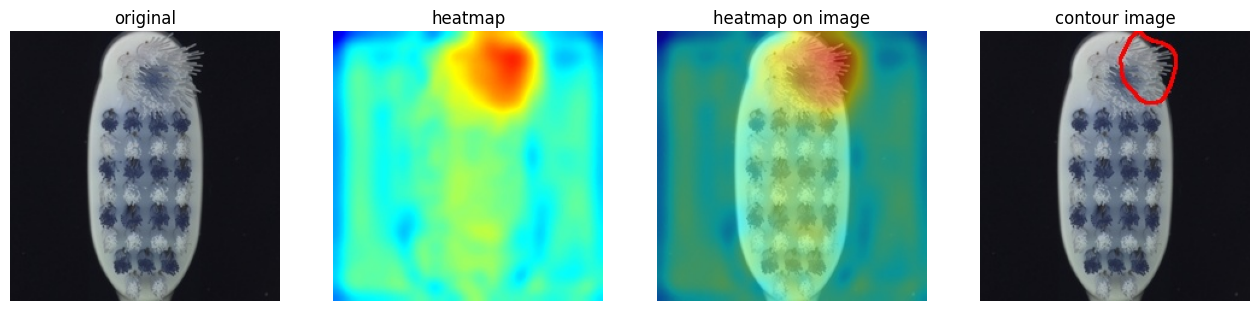

In [14]:
hm_img_image = imread('sample/anomaly/005.png_hm_on_img.jpg')
origin_image = imread('sample/anomaly/005.png.jpg')
draw_image   = imread('sample/anomaly/005.png_draw.jpg')
hm_image     = imread('sample/anomaly/005.png_hm.jpg')

images = [origin_image, hm_image, hm_img_image, draw_image]
titles = ['original', 'heatmap', 'heatmap on image', 'contour image'] 
    
show_images(images, titles)

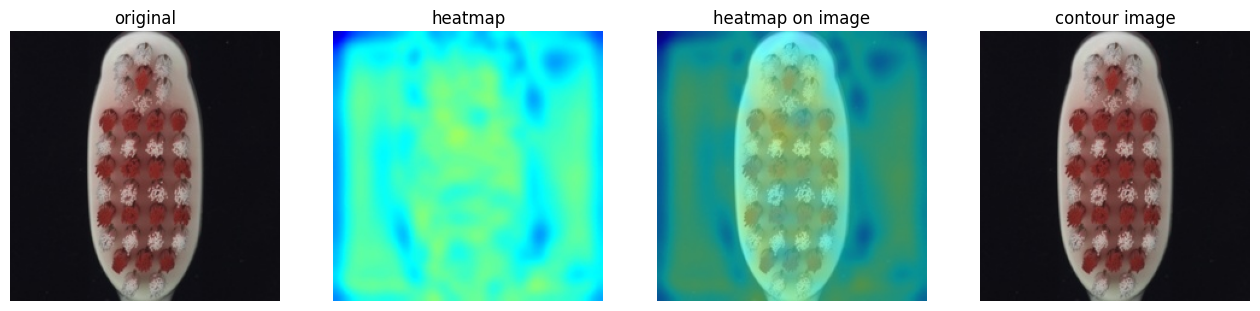

In [15]:
hm_img_image = imread('sample/good/005.png_hm_on_img.jpg')
origin_image = imread('sample/good/005.png.jpg')
draw_image   = imread('sample/good/005.png_draw.jpg')
hm_image     = imread('sample/good/005.png_hm.jpg')

images = [origin_image, hm_image, hm_img_image, draw_image]
titles = ['original', 'heatmap', 'heatmap on image', 'contour image'] 
    
show_images(images, titles)